In [31]:
!uname -a

Linux compute-0-19.local 2.6.32-642.el6.x86_64 #1 SMP Tue May 10 17:27:01 UTC 2016 x86_64 x86_64 x86_64 GNU/Linux


In [32]:
!pwd

/home/tallam/snmachine/examples


In [33]:
!pip install ../.

Processing /home/tallam/snmachine
  Running setup.py bdist_wheel for snmachine ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-jn5hr_7n/wheels/b1/b1/36/46c82415b8fb4d6dc9b2c686f32fe04fa192d416430ae0f452
Successfully built snmachine
  Found existing installation: snmachine 1.1.1
    Uninstalling snmachine-1.1.1:
      Successfully uninstalled snmachine-1.1.1


# Notebook for running the snmachine pipeline on PLAsTiCC simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the photometric light-curve astronomical time-series classification challenge (PLAsTiCC). 

See Lochner et al. (2016) http://arxiv.org/abs/1603.00882 for the original SPCC-challenge test.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [49]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo
import pickle
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Set the number of processes you want to use throughout the notebook
nproc=24
# Also please specify Data root, 
# the path to where you have pulled all the data from
rt='/share/hypatia/snmachine_resources/data/cwp/DDFY1/RH_colossus_2664_ddf_DDF_1aONLY_Y1_G10/'
dataset='colossus_2664_ddf_Y1_test'
#rt=os.path.join('/Users/cnsetzer/software/data/plasticc_all','')

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

In [51]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir=os.path.join('output_{}_no_z'.format(dataset),'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

final_outdir="/share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/output_{}_no_z/".format(dataset)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

1

## Initialise dataset object

Load a subset of the PLAsTiCC simulated data (https://arxiv.org/abs/1810.00001)

In [52]:
#rt='/share/hypatia/snmachine_resources/data/cwp/DDFY1/RH_colossus_2664_ddf_DDF_1aONLY_Y1_G10/RH_DDF_1aONLY_Y1_G10_Ia-0001_HEAD.FITS'
prefixIa='RH_DDF_1aONLY_Y1_G10_Ia-'
prefixNONIa='RH_DDF_1aONLY_Y1_G10_NONIa-'

In [54]:
dat=sndata.LSSTCadenceSimulations(folder=rt,prefix_Ia=prefixIa, prefix_NONIa=prefixNONIa, indices=[1])
#dat=sndata.plasticc_data(folder=rt,pickle_file='dataset_full.pickle',from_pickle=True)

Reading data...
chunk 01
0k
1629 objects read into memory.


In [55]:
# Get the types, note these are internal snmachine datatypes
types=dat.get_types()

Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

In [56]:
# Like for SPCC example notebook where we restrict ourselves to three supernova types:
# Ia (1), II (2) and Ibc (3) by carrying out the following pre-proccessing steps
types['Type'] = types['Type']-100

types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3
types['Type'][np.floor(types['Type']/10)==4]=4

In [57]:
types

Object,Type
str7,int32
1147929,1
1037170,1
3015084,1
1574070,1
99454,1
1830553,1
886290,1
2140119,1
3189287,1


<IPython.core.display.Javascript object>


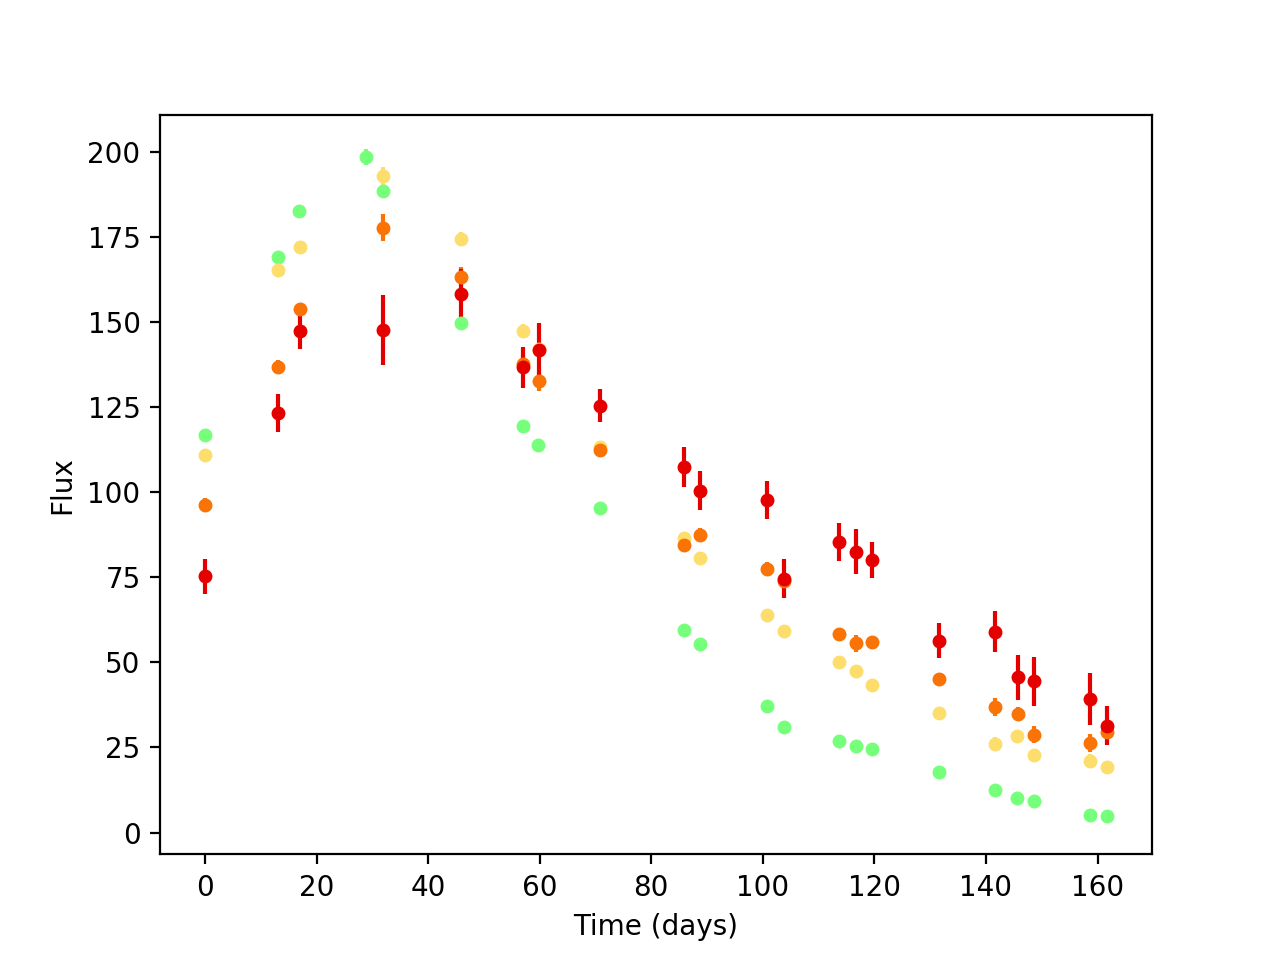

In [58]:
dat.plot_all(mix=True)

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

Note: The types listed here in the table the internal types to snmachine

In [59]:
dat.object_names[0:5]

array(['2017624', '1212599', '689328', '1022094', '1793459'],
      dtype='<U7')

In [60]:
dat.data[dat.object_names[0]]

mjd,flux,flux_error,filter,zp,zpsys
float32,float32,float32,str5,float64,str2
0.0,14.8756,1.99912,lsstr,27.5,ab
0.0152,15.027,2.48954,lssti,27.5,ab
0.0262,16.9225,3.53014,lsstz,27.5,ab
0.0371,16.2149,10.6019,lssty,27.5,ab
28.929,5.22258,1.26175,lsstr,27.5,ab
28.9442,9.35427,1.59819,lssti,27.5,ab
28.9552,13.8828,2.44864,lsstz,27.5,ab
28.9661,9.63479,7.58274,lssty,27.5,ab
66.837,1.05133,1.53981,lsstr,27.5,ab


## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file (`snmachine` by default saves to astropy tables)

In [61]:
read_from_file=False #We can use this flag to quickly rerun from saved features
run_name=os.path.join(out_features,'{}_all'.format(dataset))
read_from_pickle=False
pickle_location = rt
restart_from_GP = False
restart_from_wavefeats=False
restart_from_wavelets=False

### Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [62]:
#rt='/share/hypatia/snmachine_resources/data/plasticc/data_products/plasticc_training/without_seasongap_cutting/features/'

In [63]:
waveFeats=snfeatures.WaveletFeatures()
#wavelet_feats=snfeatures.WaveletFeatures(wavelet='sym2', ngp=100)

In [64]:
%%capture --no-stdout
if read_from_file:
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
elif read_from_pickle:
    print('THIS IS NOT CURRENTLY IMPLEMENTED')
    f = open(rt)
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
elif restart_from_GP:
    wave_features=waveFeats.extract_features(dat,nprocesses=nproc,output_root=rt,save_output='all',restart='gp')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean
    
elif restart_from_wavefeats:
    wave_features=Table.read(rt  + 'wavelet_features.fits',format='fits')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    f = open(rt+'PCA_eigenvals.pickle','rb')
    PCA_vals=pickle.load(f)
    f.close()
    f = open(rt+'PCA_eigenvectors.pickle','rb')
    PCA_vec=pickle.load(f)
    f.close()
    f = open(rt+'PCA_mean.pickle','rb')
    PCA_mean=pickle.load(f)
    f.close()
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,PCA_vals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,PCA_vec)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,PCA_mean)

elif restart_from_wavelets:
    # RESTART FROM WAVELETS
    # Copy int to finaldir and read in raw wavelets
    wavelet_feats=snfeatures.WaveletFeatures(wavelet='sym2', ngp=100)
    wave_raw, wave_err=wavelet_feats.restart_from_wavelets(dat, os.path.join(final_outdir, 'int', ''))
    wavelet_features,vals,vec,means=wavelet_feats.extract_pca(dat.object_names.copy(), wave_raw)

else:
    wave_features=waveFeats.extract_features(dat,nprocesses=nproc,output_root=out_int,save_output='all')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean

Performing Gaussian process regression
2017624
2643316
701330
2550892
2489133
1536295
2253025
1026926
1778028
1018233
560943
2980031
1557153
2874676
861658
2933318
2048650
2062329
2811097
1322593
2955660
97122
1531396
1107430
933677
529140
1011118
2557228
1738194
1672101
2865882
1226372
2758049
3046125
1060773
2932775
860507
686741
253768
1848150
1766200
1950282
2613896
1244318
1076384
2961767
590298
1682738
1647586
3131434
2555923
377646
1557795
1611771
2439610
1016047
1061127
3030914
2529757
905834
1208081
179150
578267
3031279
66357
423613
2624707
824285
1827209
818345
2047176
526511
2089689
309763
2792222
2321045
875667
1267786
2162011
2349080
67958
3176631
1564878
143180
2580662
215790
1340793
2980133
2112514
1953396
1193947
2796952
2211164
1036982
1661407
1421673
Time taken for Gaussian process regression 302.22662568092346
Performing wavelet decomposition
Time for wavelet decomposition 168.60793161392212
Running PCA...
Time for PCA 3.064798593521118


In [65]:
dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)
#dat.set_model(wavelet_feats.fit_sn,wave_features,vec,means,0,dat.get_max_length(),dat.filter_set)

Fitting transient models...
Models fitted.


<IPython.core.display.Javascript object>


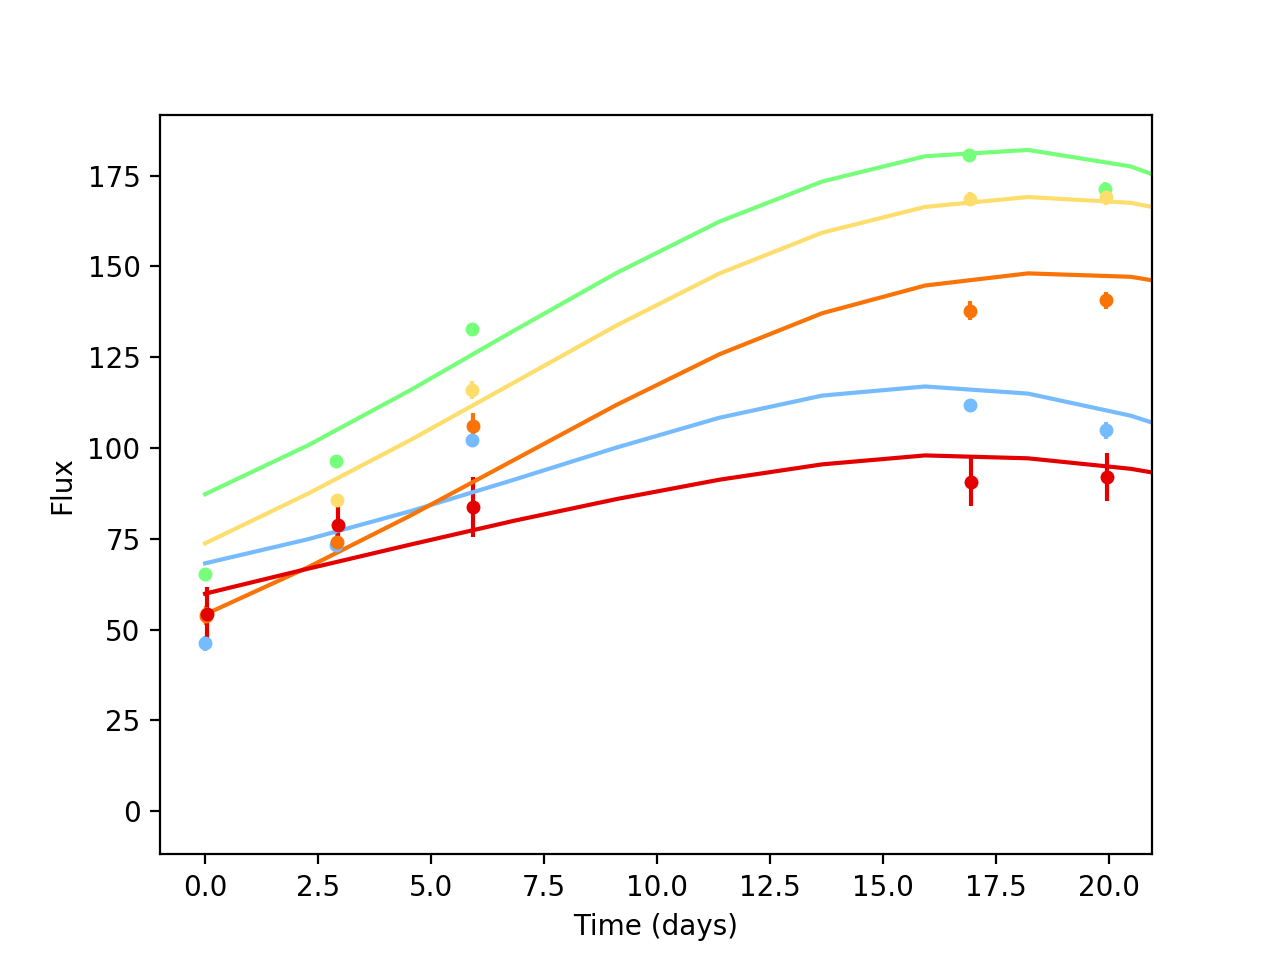

In [66]:
dat.plot_all(mix=True)

In [67]:
#d = dat.dict_2_user_types
#d = {int(k):int(v) for k,v in d.items()}
#d

### Plot t-SNE

In [68]:
#plt.figure()
#tsne_plot.plot(wave_features,join(wave_features,types)['Type'], type_dict=dat.dict_2_user_types)

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change this parameter to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [69]:
#Available classifiers 
print(snclassifier.choice_of_classifiers)

['svm', 'knn', 'random_forest', 'decision_tree', 'boost_dt', 'boost_rf', 'nb', 'neural_network']


### Combine further features

In [70]:
## TODO

#import pandas as pd
# pandas_waves = wave_features.copy().to_pandas()

# pandas_waves.set_index('Object',drop=False, inplace=True)

# new_col_df = pd.DataFrame(index = pandas_waves.index, columns=list(dat.data[dat.object_names[0]].meta.keys()))

# for o in dat.object_names:
#     for col in dat.data[o].meta.keys():
#         new_col_df.at[o,col]=dat.data[o].meta[col]
        
# pd_all_feats = pandas_waves.join(new_col_df)

# all_feats = Table.from_pandas(pd_all_feats)

# print(pd_all_feats)

<IPython.core.display.Javascript object>


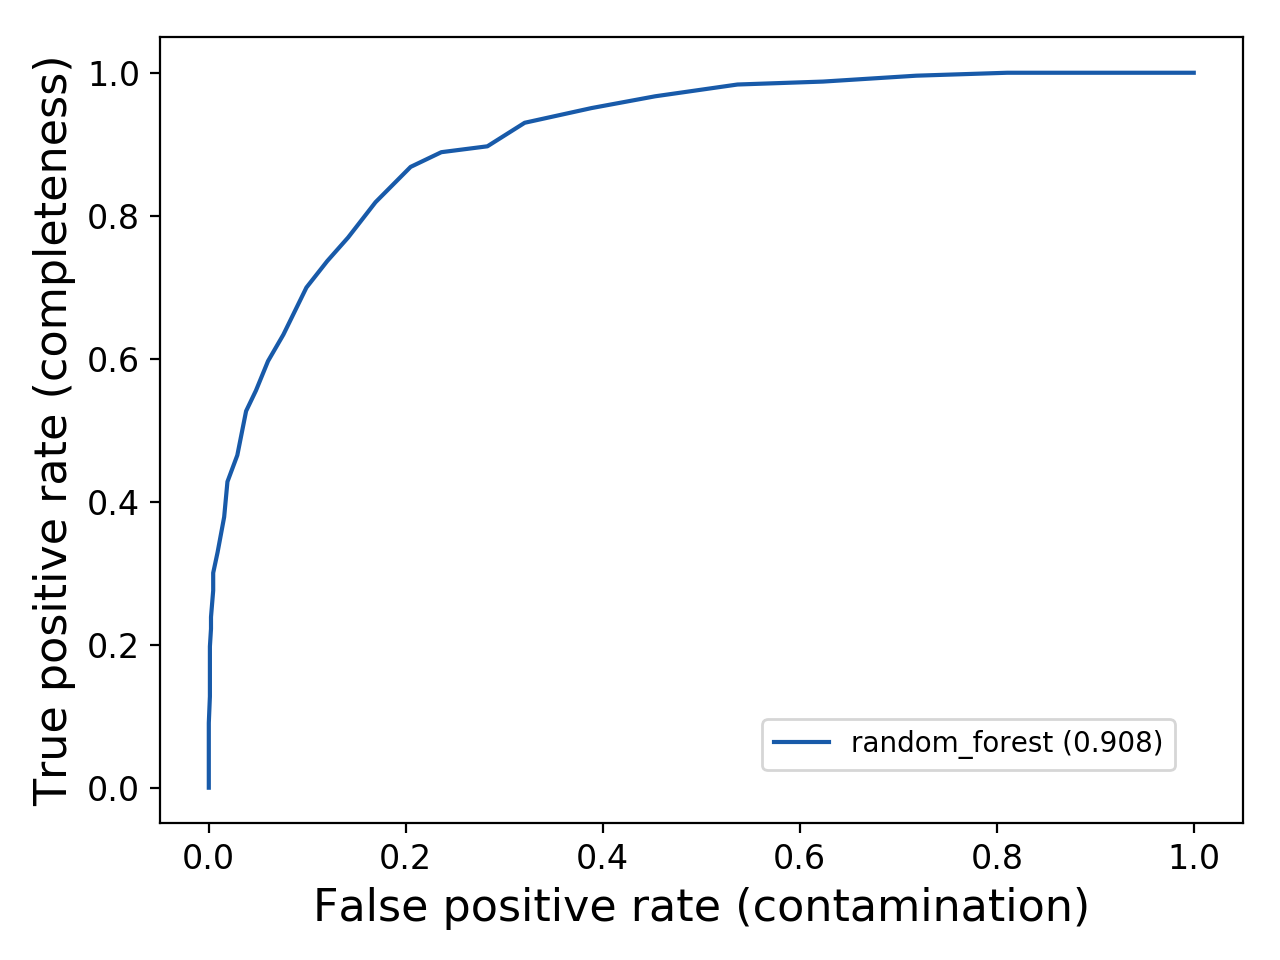

Due to limitations with python's multiprocessing module, classifier objects cannot be returned if multiple processors are used. Continuing serially...

Created classifier of type:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)



/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Optimised parameters: {'criterion': 'entropy', 'n_estimators': 300}
Classifier random_forest: AUC = 0.907943578322 FoM = 0.301702207258

Time taken  1.4978336334228515 minutes


/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/snmachine/snclassifier.py:130: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(cols)


In [71]:
fig = plt.figure()
clss, cms=snclassifier.run_pipeline(wave_features,types,output_name=os.path.join(out_class,'wavelets'),
                          classifiers=['random_forest'], nprocesses=nproc, return_classifier=True,
                              classifiers_for_cm_plots='all')

In [72]:
import seaborn as sns
from astropy.table import Table,join,unique

<IPython.core.display.Javascript object>


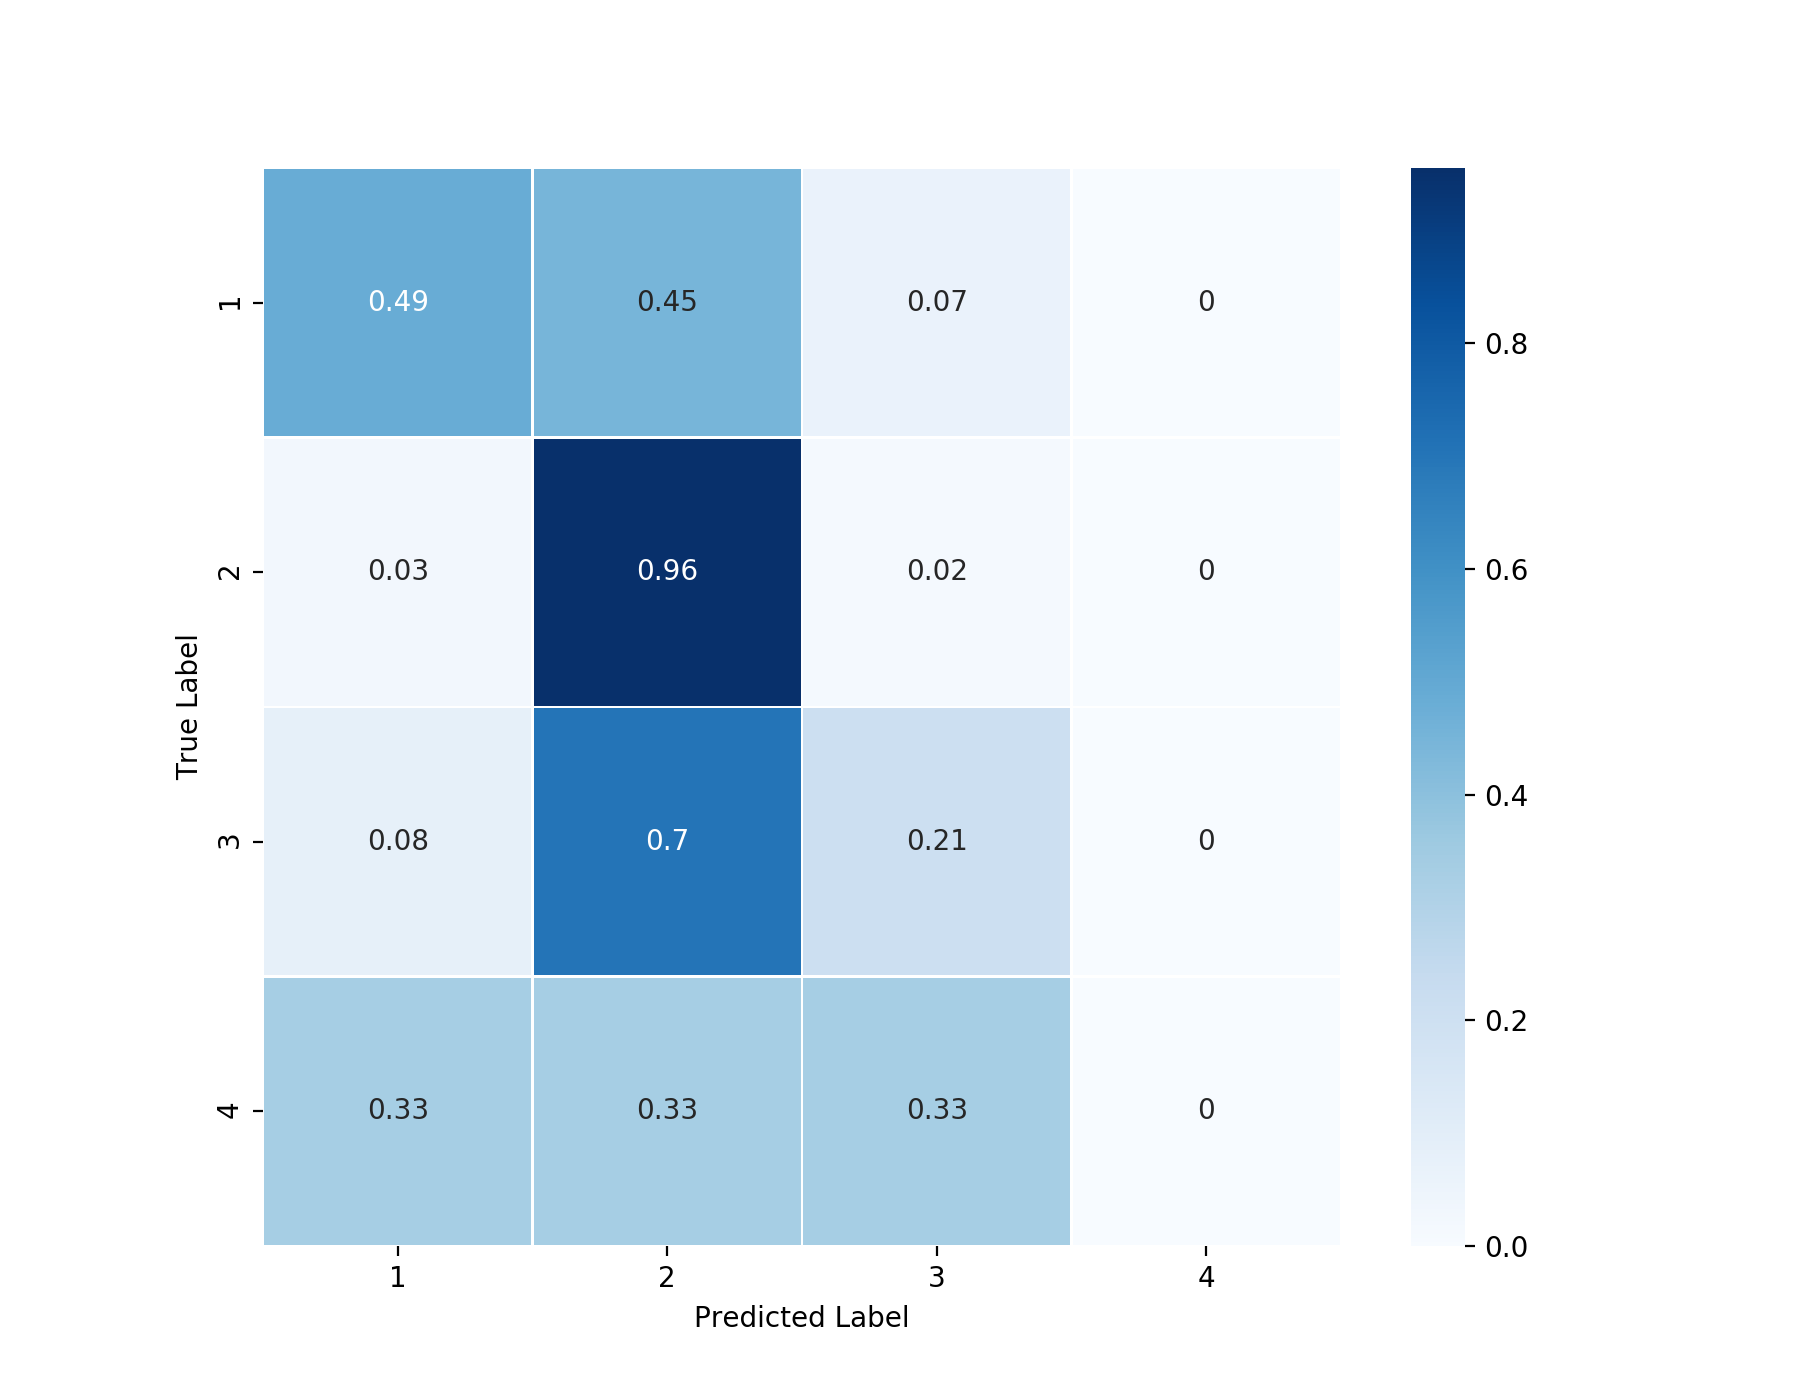

In [73]:
cm = cms[0]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

labels=[]
for tp_row in unique(types, keys='Type'):
    labels.append(tp_row['Type'])

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')